# Introduction
In this blog post, I want to show you how you can visualize the contributions of developers to your code base over time.

# Getting the data
At the beginning, we declare some general variables for easy access and to reuse them for other projects easily.

In this example, I'm using the small [Spring PetClinic GitHub repository](https://github.com/spring-projects/spring-petclinic) that's written in Java. But this approach also works for e. g. for the [Linux repo](https://github.com/torvalds/linux/) :-D.

In [67]:
PROJECT = "spring-petclinic"
PROJECT = "liferay-portal"
SOURCE_CODE_FILE_EXTENSION = ".java"
TIME_FREQUENCY = "W" # how should data be grouped? 'W' means weekly
SUFFIX = PROJECT + "_" + TIME_FREQUENCY

In the next step, we simply import an existing Git log file with file statistics that was generated using
```bash
git log --numstat --pretty=format:"%x09%x09%x09%h%x09%at%x09%aN" > git_numstat.log
```
in the Git bash console. You can find details about this approach in [Reading a Git repo's commit history with Pandas efficiently](https://www.feststelltaste.de/reading-a-git-repos-commit-history-with-pandas-efficiently/).

In [60]:
import pandas as pd

logfile = "../../{}/git_numstat.log".format(PROJECT)
git_log = pd.read_csv(
    logfile,
    sep="\t", 
    header=None,
    names=[
        'additions', 
        'deletions', 
        'filename', 
        'sha', 
        'timestamp', 
        'author'])

commits = git_log[['additions', 'deletions', 'filename']]\
    .join(git_log[['sha', 'timestamp', 'author']]\
    .fillna(method='ffill'))\
    .dropna()

commits = commits[commits['filename'].str.endswith(SOURCE_CODE_FILE_EXTENSION)]
commits['additions'] = pd.to_numeric(commits['additions'], errors='coerce').dropna()
commits['timestamp'] = pd.to_datetime(commits['timestamp'], unit="s")
commits = commits.set_index(commits['timestamp'])
commits.head()

,additions,deletions,filename,sha,timestamp,author
timestamp,,,,,,
2017-09-08 14:16:20,2.0,1.0,modules/apps/foundation/portal-security-sso/po...,21c3453,2017-09-08 14:16:20,Hugo Huijser
2017-09-08 14:16:20,2.0,1.0,modules/apps/foundation/portal-security-sso/po...,21c3453,2017-09-08 14:16:20,Hugo Huijser
2017-09-08 14:16:20,2.0,1.0,modules/apps/foundation/portal-security-sso/po...,21c3453,2017-09-08 14:16:20,Hugo Huijser
2017-09-08 14:16:20,2.0,1.0,modules/apps/foundation/portal-security-sso/po...,21c3453,2017-09-08 14:16:20,Hugo Huijser
2017-09-08 14:16:20,2.0,1.0,modules/apps/foundation/portal-security-sso/po...,21c3453,2017-09-08 14:16:20,Hugo Huijser


The next step is optional and some basic data cleaning. It just filters out any nonsense commits that were cause by wrong timestamp configuration of some committers.

In [75]:
commits = commits[commits['timestamp'] <= 'today']
initial_commit_date = commits[-1:]['timestamp'].values[0]
commits = commits[commits['timestamp'] >= initial_commit_date]

After this, we group the data by summing up all additions per author quarterly.

In [73]:
additions_over_time = commits.groupby(
    [commits['author'], 
     pd.TimeGrouper(freq=TIME_FREQUENCY)]).sum().reset_index()
#additions_over_time = additions_over_time.set_index('timestamp')
#additions_over_time.to_csv('vis/interactive_steamgraph.csv', index_label='key', header=['value', 'date'])
additions_over_time.head()

,author,timestamp,additions,deletions
0,Adam Parower,2013-07-28,18.0,9.0
1,Adam Victor Nazareth Brandizzi,2013-06-16,12.0,6318.0
2,Adam Victor Nazareth Brandizzi,2013-06-30,16.0,0.0
3,Adam Victor Nazareth Brandizzi,2013-10-13,35.0,0.0
4,Adam Victor Nazareth Brandizzi,2013-10-20,5.0,1.0


In [76]:
additions_over_time = commits.groupby(
    [commits['author'], 
     pd.TimeGrouper(freq=TIME_FREQUENCY)]).count().reset_index()
#additions_over_time = additions_over_time.set_index('timestamp')
#additions_over_time.to_csv('vis/interactive_steamgraph.csv', index_label='key', header=['value', 'date'])
additions_over_time.head()

ValueError: cannot insert timestamp, already exists

In [69]:
additions_over_time.sort_values(by='additions', ascending=False).head(10)

,author,timestamp,additions,deletions
679,Alexander Chow,2011-06-19,3988413.0,3987038.0
1002,Andrea Di Giorgi,2016-02-28,1935397.0,1935240.0
985,Andrea Di Giorgi,2015-10-25,1641778.0,1641775.0
1861,Brian Chan,2016-03-13,1236365.0,1236513.0
1697,Brian Chan,2013-01-20,997601.0,997397.0
1001,Andrea Di Giorgi,2016-02-21,963868.0,964247.0
1761,Brian Chan,2014-04-13,667973.0,667764.0
1828,Brian Chan,2015-07-26,639935.0,630917.0
16561,shuyangzhou,2016-02-07,567659.0,574530.0
8671,Marcellus Tavares,2015-07-26,456495.0,262739.0


# Ugly visualization
At this point, we could already plot the data with the built-in `plot` function of Pandas.

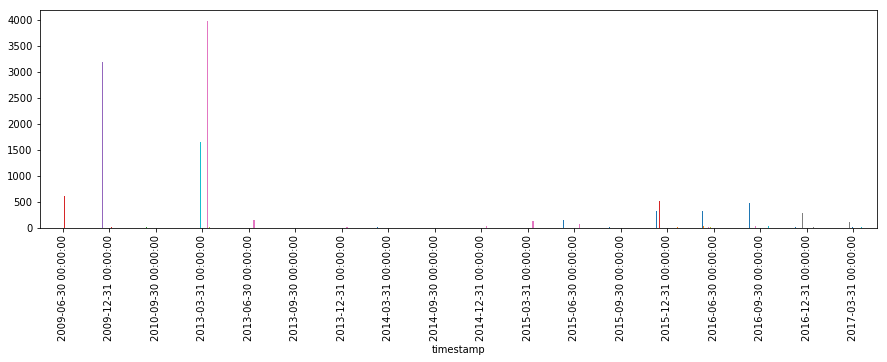

In [58]:
%matplotlib inline
additions_over_time.pivot_table(
    index=additions_over_time['timestamp'], 
    columns=['author'], 
    values=['additions']).plot(kind='bar', legend=None, figsize=(15,4))

But it doesn't look good at all :-/. But I came over a nice visualization for this that look like this:



# Treat missing data
Next, we are already preparing the data for the visualization. The D3.js template we are using needs a continuous series of timestamp data for each author. We are simply filling the existing ```additions_over_time``` DataFrame with the missing values.

In [25]:
ranges = pd.DatetimeIndex(
    start=additions_over_time.index.min(),
    end=additions_over_time.index.max(), 
    freq=TIME_FREQUENCY)
vis_data = pd.DataFrame(index=ranges).join(additions_over_time, how='outer').fillna(0)
vis_data.loc[vis_data['author'] == 0, 'author'] = None
vis_data['author'] = vis_data['author'].fillna(method='ffill')
vis_data.to_csv('vis/interactive_steamgraph.csv', header=['key', 'value', 'date'], index=None)

,author,timestamp,additions
2009-06-30 00:00:00,None,1970-01-01,0.0
2009-09-30 00:00:00,None,1970-01-01,0.0
2009-12-31 00:00:00,None,1970-01-01,0.0
2010-03-31 00:00:00,None,1970-01-01,0.0
2010-06-30 00:00:00,None,1970-01-01,0.0
2010-09-30 00:00:00,None,1970-01-01,0.0
2010-12-31 00:00:00,None,1970-01-01,0.0
2011-03-31 00:00:00,None,1970-01-01,0.0
2011-06-30 00:00:00,None,1970-01-01,0.0
2011-09-30 00:00:00,None,1970-01-01,0.0


Then we need to transform some data into the format that is needed by the D3 template and export it into a CSV file.

In [12]:
csv = vis_data.reset_index()[[
    'author',
    'additions',
    'index']]

csv = csv.sort_values(by=['author', 'index'])
csv['timestamp'] = csv['index'].dt.strftime("%m/%d/%y")
csv['additions'] = csv['additions'].apply(lambda x : int(x))
csv[['author',
    'additions',
    'timestamp']].to_csv('vis/interactive_steamgraph.csv', header=['key', 'value', 'date'], index=False)
csv.head()

,author,additions,index,timestamp
25,Antoine Rey,10,2014-03-31,03/31/14
26,Antoine Rey,0,2014-06-30,06/30/14
30,Antoine Rey,154,2015-06-30,06/30/15
33,Antoine Rey,5,2015-09-30,09/30/15
34,Antoine Rey,326,2015-12-31,12/31/15


In [15]:
import math

piv = pd.DataFrame(
    csv.pivot_table(
        index='index',
        columns=['author'],
        values=['additions']).fillna(0).unstack()).reset_index()

piv['index'] = piv['index'].dt.strftime("%m/%d/%y")
piv['additions'] = piv[0]
piv = piv[['author',
    'additions',
    'index']]

csv_filename = "interactive_steamgraph_" + SUFFIX + ".csv"
piv.to_csv("vis/" + csv_filename, header=['key', 'value', 'date'], index=False)
piv.head()

,author,additions,index
0,Antoine Rey,0.0,06/30/09
1,Antoine Rey,0.0,09/30/09
2,Antoine Rey,0.0,12/31/09
3,Antoine Rey,0.0,03/31/10
4,Antoine Rey,0.0,06/30/10


In [16]:
with open("vis/interactive_steamgraph_template.html", "r") as template:
    content = template.read()
    content = content.replace("${FILENAME}", csv_filename)
    with open("vis/interactive_steamgraph_" + SUFFIX + ".html", "w") as output_file:
        output_file.write(content)